In [3]:
from segmate import SegMate
from object_detector import GroundingDINO
import utils
import numpy as np

/scratch/ssd004/scratch/vkhazaie/sam/lib/python3.9/site-packages/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [4]:
sm = SegMate(model_type='vit_b', checkpoint='../sam_vit_b_01ec64.pth', device='cuda', object_detector=None)

In [5]:
od = GroundingDINO()

/scratch/ssd004/scratch/vkhazaie/sam/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
sm.add_object_detector(od)

In [7]:
image = utils.load_image(image_path='images/building.png')

In [8]:
image.shape

(500, 500, 3)

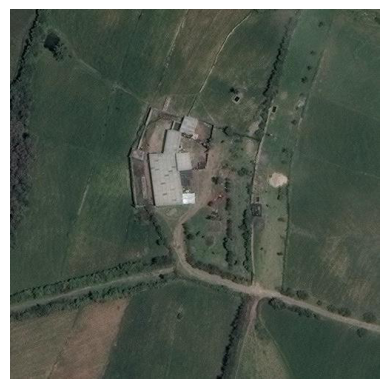

In [9]:
utils.show_image(image=image)

In [10]:
from datasets import load_dataset

dataset = load_dataset("keremberke/satellite-building-segmentation", "mini")

2023-06-12 11:19:38,847 - Found cached dataset satellite-building-segmentation (/h/vkhazaie/.cache/huggingface/datasets/keremberke___satellite-building-segmentation/mini/1.0.0/2d4f5155d8a688bdff0915214924fbee078bcc85eb80f4d3c5884b8e319ec0ea)


  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
sample = dataset['train'][0]
image = sample["image"]
bbox = sample['objects']['bbox']
seg_mask = sample['objects']['segmentation']

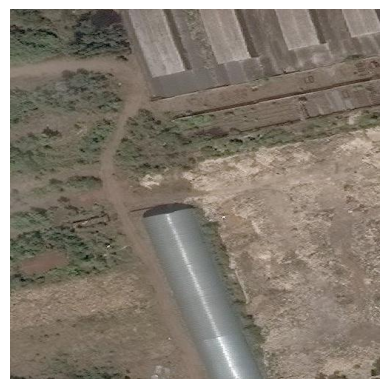

In [12]:
utils.show_image(image=image)

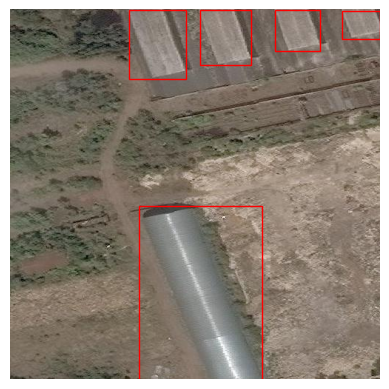

In [13]:
utils.show_bounding_boxes(image=image, bounding_boxes=bbox)

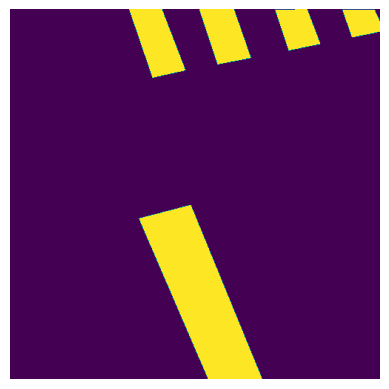

In [14]:
binary_mask = utils.get_segmentation_mask(segmentation_label=seg_mask, size=500)
utils.show_image(binary_mask.reshape(500, 500))

In [15]:
masks = sm.auto_segment(image=np.array(image))

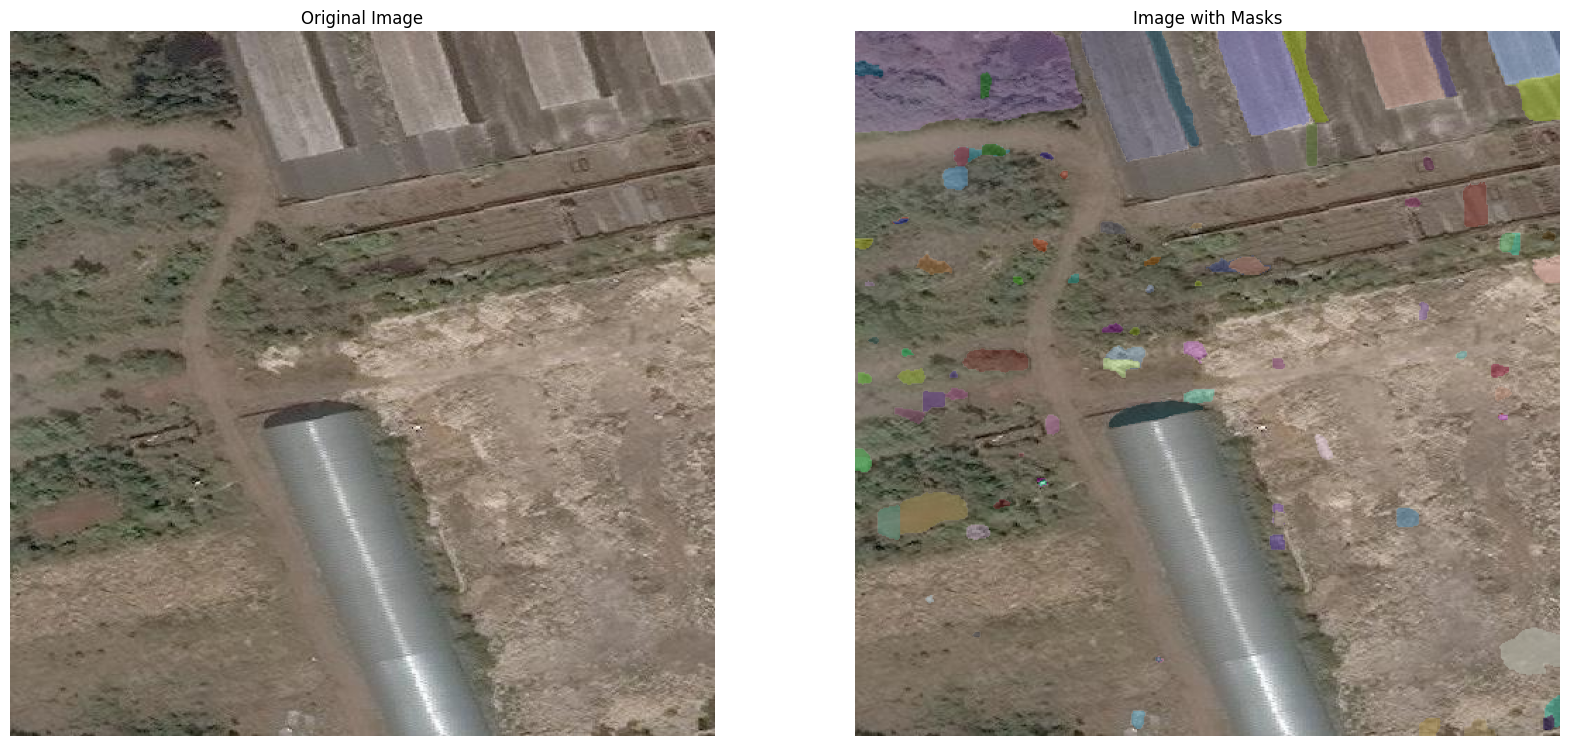

In [16]:
sm.visualize_automask(image=np.array(image), masks=masks)

In [17]:
masks = sm.segment(image=np.array(image), boxes_prompt=utils.convert_bboxes(bbox))

In [18]:
masks.shape

(5, 3, 500, 500)

In [19]:
# mask = utils.binarize_mask(masks, sum_all_masks=True)

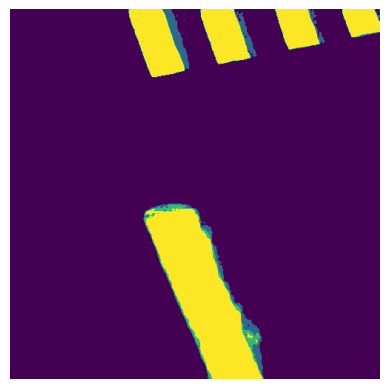

In [20]:
utils.show_image(masks.sum(0).sum(0).reshape(500, 500, 1))

In [22]:
# masks = sm.segment(image=np.array(image), text_prompt=["building", 0.35, 0.35])